### Load dataset

In [1]:
import os
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists
from os import makedirs

In [2]:
run_name = "verysmall_unbalanced"
wandb.init(project="binary_search_optimization", name=run_name)

W&B Run: https://app.wandb.ai/panuthep/binary_search_optimization/runs/wk82j1db

In [3]:
DATASET_DIR = "./datasets/dataset_verysmall.pkl"
WEIGHTS_DIR = join("./save_weights", run_name)
if not exists(WEIGHTS_DIR):
    makedirs(WEIGHTS_DIR)

MAX_MONSTER_NUM = 1000
MONSTER_HPS_COL = ["monster_hp_" + str(num) for num in range(1, MAX_MONSTER_NUM + 1)]
FEATURES_COL = ["focus_damage", "aoe_damage", *MONSTER_HPS_COL]
TARGET_COL = ["attack_num"]

In [4]:
dataset = pd.read_pickle(DATASET_DIR)

# Log data distribution
for col in ["focus_damage", "aoe_damage", "attack_num"]:
    plt.hist(dataset[col])
    wandb.log({col: plt})

/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



### Train test split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
bins = np.linspace(dataset[TARGET_COL].to_numpy().min(), dataset[TARGET_COL].to_numpy().max(), 100, dtype=int)
Y_bin = np.digitize(dataset[TARGET_COL].to_numpy(), bins)

try:
    train_set, test_set = train_test_split(dataset, random_state=42, shuffle=True, stratify=Y_bin)
except:
    train_set, test_set = train_test_split(dataset, random_state=42, shuffle=True)

X_train, Y_train = train_set[FEATURES_COL].to_numpy(), train_set[TARGET_COL].to_numpy()
X_test, Y_test = test_set[FEATURES_COL].to_numpy(), test_set[TARGET_COL].to_numpy()

In [7]:
len(X_train), len(X_test)

(68250, 22750)

### Normalization

In [8]:
import joblib
from sklearn.preprocessing import MinMaxScaler

In [9]:
X_scaler = MinMaxScaler() if not exists(join(WEIGHTS_DIR, "X_scaler.pkl")) else joblib.load(join(WEIGHTS_DIR, "X_scaler.pkl"))
X_train_scaled = X_scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = X_scaler.transform(X_test.astype(np.float32))

Y_scaler = MinMaxScaler() if not exists(join(WEIGHTS_DIR, "Y_scaler.pkl")) else joblib.load(join(WEIGHTS_DIR, "Y_scaler.pkl"))
Y_train_scaled = Y_scaler.fit_transform(Y_train.astype(np.float32))
Y_test_scaled = Y_scaler.transform(Y_test.astype(np.float32))

In [10]:
# Save parameters for scalers
joblib.dump(X_scaler, join(WEIGHTS_DIR, "X_scaler.pkl"))
joblib.dump(Y_scaler, join(WEIGHTS_DIR, "Y_scaler.pkl"))

['./save_weights/verysmall_unbalanced/Y_scaler.pkl']

### Model

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MAE
from utilities import LearningRateFinder

In [12]:
wandb.config.network_depth = 1
wandb.config.network_width = 16
wandb.config.activation = "LeakyReLU"
wandb.config.optimizer = "Adam"
wandb.config.loss = "MAE"
wandb.config.epochs = 160
wandb.config.batch_size = 32
wandb.config.validation_split = 0.2

In [13]:
class SequenceDense(Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = []
        for _ in range(wandb.config.network_depth):
            self.hidden_layers.append(Dense(wandb.config.network_width, activation=LeakyReLU()))
        self.output_layer = Dense(1, activation="relu")
        
    def call(self, inputs):
        output = inputs
        for layer in self.hidden_layers:
            output = layer(output)
        output = self.output_layer(output)
        
        return output

Train on 68250 samples
Epoch 1/20
68250/68250 [==============================] - 3s 41us/sample - loss: 0.0950
Epoch 2/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.0950
Epoch 3/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.0949
Epoch 4/20
68250/68250 [==============================] - 2s 36us/sample - loss: 0.0939
Epoch 5/20
68250/68250 [==============================] - 2s 36us/sample - loss: 0.0908
Epoch 6/20
68250/68250 [==============================] - 2s 36us/sample - loss: 0.0848
Epoch 7/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.0788
Epoch 8/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0710
Epoch 9/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0615
Epoch 10/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0510
Epoch 11/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.0472
Epoch 1

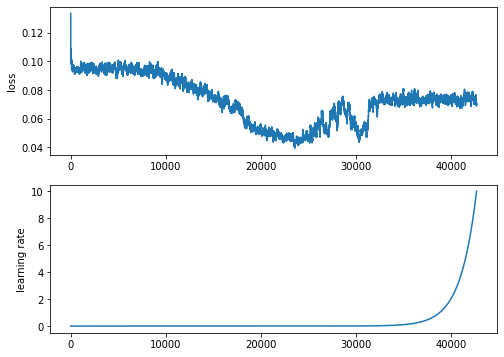

In [14]:
model_name = "model_{}_{}".format(wandb.config.network_depth, wandb.config.network_width)

model = SequenceDense()
model.build(input_shape=X_train_scaled.shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")
try:
    model.load_weights(join("./save_weights", model_name))
except:
    model.save_weights(join("./save_weights", model_name))

lr_finder = LearningRateFinder(model)
lr_finder.find((X_train_scaled, Y_train_scaled), start_lr=1e-10, epochs=20)
lr_finder.plot()

In [15]:
plt.plot(lr_finder.losses)
wandb.log({"lr_finder": plt})

/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



In [16]:
lr = lr_finder.lrs[20000]
wandb.log({"learning_rate": lr})
wandb.log({"learning_rate_index": 20000})

Train on 54600 samples, validate on 13650 samples
Epoch 1/160
54600/54600 [==============================] - 2s 38us/sample - loss: 0.0601 - val_loss: 0.0507
Epoch 2/160
54600/54600 [==============================] - 2s 32us/sample - loss: 0.0499 - val_loss: 0.0508
Epoch 3/160
54600/54600 [==============================] - 2s 31us/sample - loss: 0.0476 - val_loss: 0.0469
Epoch 4/160
54600/54600 [==============================] - 2s 31us/sample - loss: 0.0462 - val_loss: 0.0459
Epoch 5/160
54600/54600 [==============================] - 2s 32us/sample - loss: 0.0448 - val_loss: 0.0439
Epoch 6/160
54600/54600 [==============================] - 2s 33us/sample - loss: 0.0439 - val_loss: 0.0439
Epoch 7/160
54600/54600 [==============================] - 2s 34us/sample - loss: 0.0427 - val_loss: 0.0421
Epoch 8/160
54600/54600 [==============================] - 2s 37us/sample - loss: 0.0414 - val_loss: 0.0404
Epoch 9/160
54600/54600 [==============================] - 2s 37us/sample - loss: 0.04

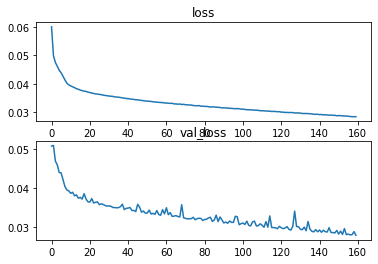

In [17]:
def history_plot(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.subplot(2, 1, 1)
    plt.title("loss")
    plt.plot(loss)
    plt.subplot(2, 1, 2)
    plt.title("val_loss")
    plt.plot(val_loss)

model = SequenceDense()
model.build(input_shape=X_train_scaled.shape)
model.compile(optimizer=Adam(learning_rate=lr_finder.lrs[20000]), loss="mae")
model.load_weights(join("./save_weights", model_name))
history = model.fit(X_train_scaled, Y_train_scaled, 
                    epochs=wandb.config.epochs, 
                    batch_size=wandb.config.batch_size, 
                    validation_split=wandb.config.validation_split, 
                    verbose=1)
model.save_weights(join(WEIGHTS_DIR, "model_trained", model_name))

history_plot(history)

In [18]:
loss = history.history["loss"]
plt.title("train_loss")
plt.plot(loss)
wandb.log({"train_loss": plt})

val_loss = history.history["val_loss"]
plt.title("val_loss")
plt.plot(loss)
wandb.log({"val_loss": plt})

test_loss = model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)
wandb.log({"test_loss": test_loss})

/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



Average loss: 0.027920646592974663


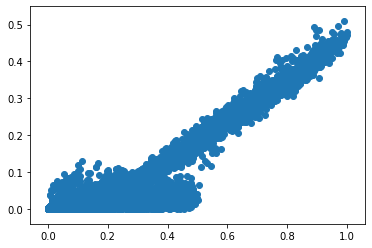

In [19]:
pred = model.predict(X_train_scaled)
loss = MAE(Y_train_scaled, pred)
plt.scatter(Y_train_scaled, loss)
wandb.log({"loss_dist": wandb.Image(plt, caption="loss_dist")})
print("Average loss: {}".format(np.mean(loss.numpy())))